# word2vec

In [530]:
import pandas as pd
import random
import os
import gensim
import csv
import nltk as nl
from sklearn.linear_model import LogisticRegression
import naive_bayes
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec

messages = []
labels = []
with open("balanced.tsv", 'r', newline='', encoding='utf8') as tsv_file:
    reader = csv.reader(tsv_file, delimiter='\t')
    for label, message in reader:
        if label != '':
            messages.append(message)
            labels.append(1 if label == '1' else 0)
tokens = []
for sentence in messages:
    tokens.append(naive_bayes.get_words(sentence))
# model = gensim.models.Word2Vec(tokens, size=100, min_count=1, workers=4, window = 5, sg = 1)

# mean = np.zeros(100)
# for token in tokens: # len(tokens) = 668
#     mean = np.zeros(100)
#     for word in token:
#         ind = model.wv.vocab[word].index # dict key: 'female', value: self defined object, ind 9
#         mean = np.add(mean, model.wv.syn0[ind]) # list: syn0[9] = female vector
#     length = 1
#     if len(token) != 0:
#         length = len(token)
#     output.append(np.true_divide(mean, length))

# print(model.wv.vocab['female'].index)
# print(model.wv.syn0[0])

In [483]:
model = Word2Vec(size=100, min_count=2, workers=4, window=7)
model.build_vocab([x for x in tokens])
model.train(tokens, total_examples=model.corpus_count, epochs=model.epochs)
output = []
for i in range(len(labels)):
    output.append(model_doc.infer_vector(tokens[i], steps=20))

# split data

In [484]:
labels = np.asarray(labels)
output = np.asarray(output)
train_output, test_output, train_label, test_label = train_test_split(output, labels, test_size=0.2, random_state=42)

# logistic regression

In [485]:
clf = LogisticRegression(random_state=0, solver='lbfgs').fit(train_output, train_label)
score = clf.score(test_output, test_label)
print(score)

0.6666666666666666


In [486]:
out = clf.predict(train_output)
confusion_matrix(train_label, out )

array([[308,  52],
       [145, 175]], dtype=int64)

In [234]:
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.688


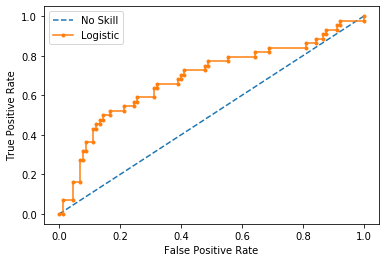

In [461]:
ns_probs = [0 for _ in range(len(test_label))]
lr_probs = clf.predict_proba(test_output)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(test_label, ns_probs)
lr_auc = roc_auc_score(test_label, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_label, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_label, lr_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# XGBoost

In [464]:
w2v_weights = model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [12]:
import sys
!{sys.executable} -m pip install xgboost

In [487]:
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

In [495]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(np.array(train_output), np.array(train_label))
print(confusion_matrix(test_label, xgb_model.predict(test_output)))

[[69 23]
 [19 60]]


In [518]:
(69+60)/(19+23+69+60)

0.7543859649122807

In [540]:
(.710+.667)/2

0.6885

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.805


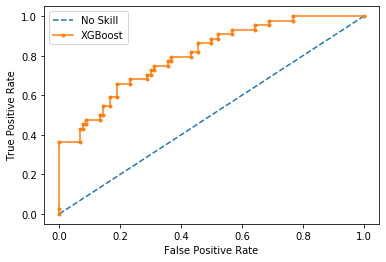

In [240]:
ns_probs = [0 for _ in range(len(test_label))]
lr_probs = xgb_model.predict_proba(test_output)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(test_label, ns_probs)
lr_auc = roc_auc_score(test_label, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_label, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_label, lr_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# LSTM

In [242]:
!pip install tensorflow
!pip install keras

^C


In [309]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences

In [310]:
np.array(output).shape, np.array(labels).shape

((851, 100), (851,))

In [311]:
MAX_SEQUENCE_LENGTH = 200
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
lstm_model.add(Bidirectional(LSTM(200)))
lstm_model.add(Dense(1,activation='softmax'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(np.array(train_output), np.array(train_label), epochs=5, batch_size=30, validation_data = (test_output, test_label), verbose=1)

Epoch 1/5
23/23 [==============================] - 7s 304ms/step - loss: 8.0731 - accuracy: 0.4706 - val_loss: 8.2043 - val_accuracy: 0.4620
Epoch 2/5
23/23 [==============================] - 5s 202ms/step - loss: 8.0731 - accuracy: 0.4706 - val_loss: 8.2043 - val_accuracy: 0.4620
Epoch 3/5
23/23 [==============================] - 5s 202ms/step - loss: 8.0731 - accuracy: 0.4706 - val_loss: 8.2043 - val_accuracy: 0.4620
Epoch 4/5
23/23 [==============================] - 5s 235ms/step - loss: 8.0731 - accuracy: 0.4706 - val_loss: 8.2043 - val_accuracy: 0.4620
Epoch 5/5
23/23 [==============================] - 5s 219ms/step - loss: 8.0731 - accuracy: 0.4706 - val_loss: 8.2043 - val_accuracy: 0.4620


# doc2vec

In [531]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm

In [532]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(tokens))
model_doc = Doc2Vec(vector_size=100, min_count=2, epochs=30, workers=4, window=7)
model_doc.build_vocab([x for x in tqdm(data_for_training)])
model_doc.train(data_for_training, total_examples=model_doc.corpus_count, epochs=model_doc.epochs)
vec_list = []
for i in range(len(labels)):
    vec_list.append(model_doc.infer_vector(data_for_training[i].words, steps=20))




100%|████████████████████████████████████████████████████████████████████████████| 851/851 [00:00<00:00, 854320.90it/s]


# split data

In [534]:
labels2 = np.asarray(labels)
output2 = np.asarray(vec_list)
train_output2, test_output2, train_label2, test_label2 = train_test_split(output2, labels2, test_size=0.2, random_state=42)

# logistic regression

In [338]:
clf2 = LogisticRegression(random_state=0, solver='lbfgs').fit(train_output2, train_label2)
score2 = clf2.score(test_output2, test_label2)
print(score2)

0.6549707602339181


In [492]:
out2 = clf2.predict(train_output2)
confusion_matrix(train_label2, out2 )

array([[304,  56],
       [142, 178]], dtype=int64)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.698


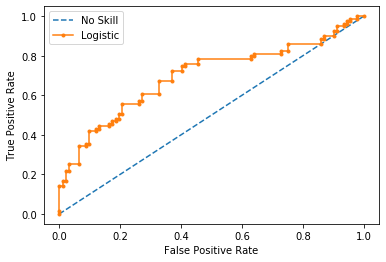

In [356]:
ns_probs = [0 for _ in range(len(test_label2))]
lr_probs = clf2.predict_proba(test_output2)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(test_label2, ns_probs)
lr_auc = roc_auc_score(test_label2, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_label2, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_label2, lr_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# XGBoost

In [536]:
xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model2.fit(np.array(train_output2), np.array(train_label2))
print(confusion_matrix(test_label2, xgb_model.predict(test_output2)))

[[66 26]
 [27 52]]


In [353]:
(91+10)/(91+10+1+69)

0.5906432748538012

No Skill: ROC AUC=0.500
XGBoost: ROC AUC=0.605


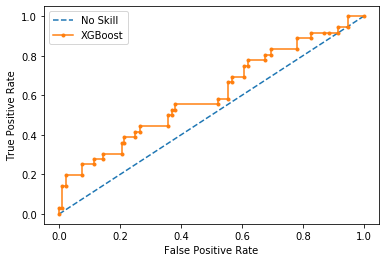

In [26]:
ns_probs = [0 for _ in range(len(test_label2))]
lr_probs = xgb_model2.predict_proba(test_output2)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(test_label2, ns_probs)
lr_auc = roc_auc_score(test_label2, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGBoost: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_label2, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_label2, lr_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# LSTM

In [358]:
MAX_SEQUENCE_LENGTH = 200
lstm_model2 = Sequential()
lstm_model2.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
lstm_model2.add(Bidirectional(LSTM(100)))
lstm_model2.add(Dense(1,activation='softmax'))
lstm_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model2.fit(np.array(vec_list), np.array(labels), epochs=5, batch_size=30, verbose=1)

Epoch 1/5
29/29 [==============================] - 2s 75ms/step - loss: 8.0995 - accuracy: 0.4689
Epoch 2/5
29/29 [==============================] - 2s 74ms/step - loss: 8.0995 - accuracy: 0.4689
Epoch 3/5
29/29 [==============================] - 2s 82ms/step - loss: 8.0995 - accuracy: 0.4689
Epoch 4/5
29/29 [==============================] - 2s 77ms/step - loss: 8.0995 - accuracy: 0.4689
Epoch 5/5
29/29 [==============================] - 2s 62ms/step - loss: 8.0995 - accuracy: 0.4689
